In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker
from scipy.integrate import simps, trapz

import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : True ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : True ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

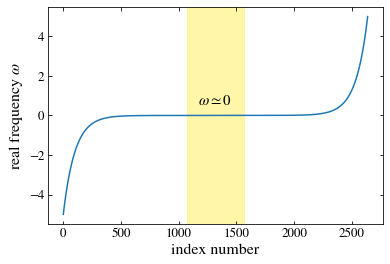

In [2]:
D = 1
out_node = 2
directory = '../1_dmftsolver/NRG'

w, A,Gr,Gi,_,_,_,_,_,_ = np.loadtxt(f'{directory}/Bethe_14_beta10000/Bethe-{2.5:.3f}.dat', \
                       unpack = True, dtype = 'complex128')
plt.plot(w.real)
plt.ylabel(r'real frequency $\omega$')
plt.xlabel('index number')
plt.axvspan(1319-250, 1319+250, alpha=0.5, color='#ffee52')
plt.annotate(r'$\omega\simeq0$', xy=(0.5, 0.55), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.savefig('index2w.png')
plt.show()

# Data

In [4]:
beta = 10000
U_c1_4, U_c2_4 = 2.25, 2.9
    
w_len = len(np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{2.000:.3f}.dat', \
                       unpack = True, dtype = 'complex128')[0])

up_num = 229
dn_num = 242

U = np.array([0.001*i for i in range(600, 5001)])
U1_4 = np.zeros(up_num, dtype = 'float64')
U2_4 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_4[n] = u
    n += 1
    
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_4[n] = u
    n += 1
    
x_test_4 = np.zeros((len(U1_4)+len(U2_4), 2638*2), dtype = 'float64')
UU1 = U1_4[U1_4<2.1]
UU2 = U2_4[U2_4>3.0]
x = np.zeros((len(UU1)+len(UU2), 2638*2), dtype = 'float64')

# train data
for i, u in enumerate(UU1):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x[i, :2638], x[i, 2638:] = ((D/2)**2*G_r), ((D/2)**2*G_i)
for i, u in enumerate(UU2):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x[i+len(UU1), :2638], x[i+len(UU1), 2638:] = ((D/2)**2*G_r), ((D/2)**2*G_i)
x = -torch.FloatTensor(x)
size = len(x[0])

# test data
for i, u in enumerate(U1_4):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_4[i, :2638], x_test_4[i, 2638:] = ((D/2)**2*G_r), ((D/2)**2*G_i)
for i, u in enumerate(U2_4):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_4[i+len(U1_4), :2638], x_test_4[i+len(U1_4), 2638:] = ((D/2)**2*G_r), ((D/2)**2*G_i)
x_test_4 = -torch.FloatTensor(x_test_4)


# Metal = 1, Insulator = 0
y_temp1 = np.array(UU1 < U_c2_4)
y_temp2 = np.array(UU2 < U_c1_4)
y_temp = np.concatenate([y_temp1, y_temp2])
y = np.stack([y_temp, ~y_temp], axis = 1)
y = torch.FloatTensor(y)

y_temp1 = np.array(U1_4 < U_c2_4)
y_temp2 = np.array(U2_4 < U_c1_4)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_4 = np.stack([y_temp, ~y_temp], axis = 1)
y_test_4 = torch.FloatTensor(y_test_4)
UU_4 = np.concatenate((U1_4, U2_4))

def divide(x_,y_):
    a = np.concatenate([np.zeros(int(len(x_)/5)), np.ones(len(x_)-int(len(x_)/5))])
    np.random.shuffle(a)
    mask = a > 0.5
    x_train, x_val = x_[mask], x_[~mask]
    y_train, y_val = y_[mask], y_[~mask]
    return x_train, x_val, y_train, y_val
x_train, x_val, y_train, y_val = divide(x, y)

In [4]:
'''
beta=1000
U_c1_3, U_c2_3 = 2.225, 2.69

up_num = 50
dn_num = 60

U1_3 = np.zeros(up_num, dtype = 'float64')
U2_3 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_3[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_3[n] = u
    n += 1
    
x_test_3 = np.zeros((len(U1_3)+len(U2_3), 2638), dtype = 'float64')
UU1 = U1_3[U1_3<U_c1_3]
UU2 = U2_3[U2_3>U_c2_3]

# test data
for i, u in enumerate(U1_3):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_3[i] = ((D/2)**2*G_i)
for i, u in enumerate(U2_3):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_3[i+len(U1_3)] = ((D/2)**2*G_i)
x_test_3 = -torch.FloatTensor(x_test_3)
y_temp1 = np.array(U1_3 < U_c2_3)
y_temp2 = np.array(U2_3 < U_c1_3)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_3 = np.stack([y_temp, ~y_temp], axis = 1)
y_test_3 = torch.FloatTensor(y_test_3)
UU_3 = np.concatenate((U1_3, U2_3))
'''
beta=100
U_c1_2, U_c2_2 = 2.22, 2.5

up_num = 31
dn_num = 64

U1_2 = np.zeros(up_num, dtype = 'float64')
U2_2 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_2[n] = u
    n += 1
    
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_2[n] = u
    n += 1
    
x_test_2 = np.zeros((len(U1_2)+len(U2_2), 2638*2), dtype = 'float64')
UU1 = U1_2[U1_2<U_c1_2]
UU2 = U2_2[U2_2>U_c2_2]

# test data
for i, u in enumerate(U1_2):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_2[i, :2638], x_test_2[i, 2638:] = ((D/2)**2*G_r), ((D/2)**2*G_i)
for i, u in enumerate(U2_2):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_2[i+len(U1_2), :2638], x_test_2[i+len(U1_2), 2638:] = ((D/2)**2*G_r), ((D/2)**2*G_i)
x_test_2 = -torch.FloatTensor(x_test_2)

y_temp1 = np.array(U1_2 < U_c2_2)
y_temp2 = np.array(U2_2 < U_c1_2)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_2 = np.stack([y_temp, ~y_temp], axis = 1)
y_test_2 = torch.FloatTensor(y_test_2)
UU_2 = np.concatenate((U1_2, U2_2))

# Neural Network

In [6]:
class Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node)#, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        #self.W1.weight.data.fill_(0)
        nn.init.uniform_(self.W1.weight, -0.001, 0.001)
        #nn.init.uniform_(self.W2.weight, -0.001, 0.001)
        nn.init.xavier_normal_(self.W2.weight)
        #nn.init.uniform_(self.W1.weight.data[:, 1319-200:1319+200], -0.1, 0.1)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)
        '''
        if (activate==nn.Sigmoid or activate==nn.Tanh):
            nn.init.xavier_normal_(self.W1.weight)
            nn.init.xavier_normal_(self.W2.weight)
        else:
            nn.init.kaiming_normal_(self.W1.weight)
            nn.init.kaiming_normal_(self.W2.weight)
        '''

    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)

    def loss1(self, output, y, reg): # regularization l1
        regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    def loss2(self, output, y, reg): # regularization l2
        regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss

    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

# Training

In [8]:
learning_rate = 1e-3
reg = 1e-5
h_node = 100
func = nn.Sigmoid # activation function
model = Net(node = h_node, activate = func)

# Begin training and validation
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
n_epochs = 10000
train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(n_epochs+1), np.ones(n_epochs+1)
for epoch in range (n_epochs+1):
    loss = model.loss1(model.forward(x_train), y_train, reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valid_loss = model.loss1(model.forward(x_val), y_val, reg).item()
    t_acc = model.accuracy(model.forward(x_test_4), y_test_4)
    train_loss[epoch], val_loss[epoch], test_acc[epoch] = loss.item(), valid_loss, t_acc

    if epoch%int(n_epochs/10) == 0:
        print('epoch = %d, training loss = %.6f, valid loss = %.6f, accuracy = %.8f' \
                %(epoch, loss.item(), valid_loss, t_acc))
    
    if epoch > 499 and np.average(val_loss[:-50]) > np.average(val_loss): break

epoch = 0, training loss = 0.725053, valid loss = 0.728157, accuracy = 0.50000000
epoch = 1000, training loss = 0.230143, valid loss = 0.225739, accuracy = 0.99256900
epoch = 2000, training loss = 0.142941, valid loss = 0.141033, accuracy = 0.99150743
epoch = 3000, training loss = 0.103293, valid loss = 0.102161, accuracy = 0.99150743
epoch = 4000, training loss = 0.080754, valid loss = 0.079961, accuracy = 0.99256900
epoch = 5000, training loss = 0.066359, valid loss = 0.065750, accuracy = 0.99256900
epoch = 6000, training loss = 0.056457, valid loss = 0.055962, accuracy = 0.99363057
epoch = 7000, training loss = 0.049282, valid loss = 0.048863, accuracy = 0.99363057
epoch = 8000, training loss = 0.043874, valid loss = 0.043510, accuracy = 0.99363057
epoch = 9000, training loss = 0.039672, valid loss = 0.039350, accuracy = 0.99363057


In [9]:
epoch

9997

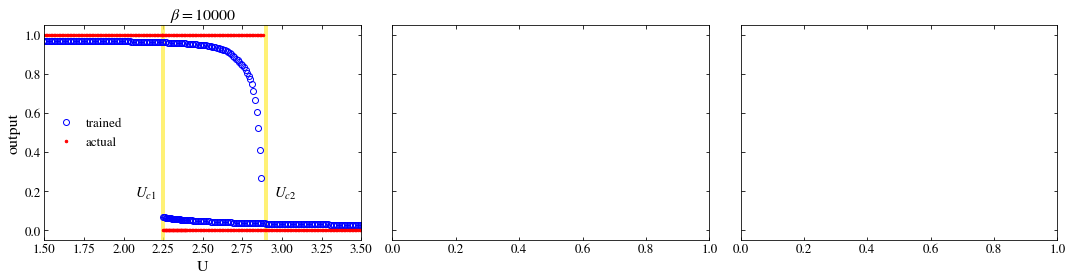

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15, 4), sharey=True)


ax[0].axvline(U_c1_4, c = '#ffee52', lw = '4',  alpha=0.8)
ax[0].axvline(U_c2_4, c = '#ffee52', lw = '4',  alpha=0.8)
ax[0].plot(UU_4, model.forward(x_test_4).data[:,0], 'bo', mfc='none', label = 'trained')
#ax[0].plot(UU_4, x_test_4[:,1319]/torch.max(x_test_4[:, 1319]), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
ax[0].plot(UU_4, y_test_4[:,0], 'r.', ms = 5, label = 'actual')
ax[0].set_xlim(1.5, 3.5)
ax[0].set_ylabel('output')
ax[0].set_xlabel('U')
ax[0].annotate(r'$U_{c1}$', xy=(0.32, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[0].annotate(r'$U_{c2}$', xy=(0.76, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[0].set_title(r'$\beta=10000$', fontsize=16)
ax[0].legend(loc='center left')


'''
ax[2].axvline(U_c1_2, c = '#ffee52', lw = '4',  alpha=0.8)
ax[2].axvline(U_c2_2, c = '#ffee52', lw = '4',  alpha=0.8)
ax[2].plot(UU_2, model.forward(x_test_2).data[:,0], 'bo', mfc='none', label = 'trained')
#ax[2].plot(UU_2, x_test_2[:,1319]/torch.max(x_test_2[:, 1319]), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
ax[2].plot(UU_2, y_test_2[:,0], 'r.', ms = 5, label = 'actual')
ax[2].set_xlim(1.5, 3.5)
ax[2].set_xlabel('U')
ax[2].annotate(r'$U_{c1}$', xy=(0.305, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[2].annotate(r'$U_{c2}$', xy=(0.56, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[2].set_title(r'$\beta=100$', fontsize=16)
ax[2].legend()'''

plt.tight_layout(w_pad=1.5)
#plt.savefig(f'LogisticRegression_output_u0.01.png')

In [28]:
npoint = 2001
weq = np.linspace(-5, 5, npoint)
weqind = np.zeros(npoint, dtype=int)
weqalp = np.zeros_like(weq)


def dat2f(datw, rw):
    for i, w in enumerate(datw):
        if rw < w: break
    a = (w-rw) / (w-datw[i-1])
    return i, a
for i,wq in enumerate(weq):
    weqind[i], weqalp[i] = dat2f(w.real, wq)
    
def G2Geq(datG, rw):
    Giweq = np.zeros_like(weq)
    for i,wqind in enumerate(weqind):
        Giweq[i] = datG[wqind]*(1-weqalp[i]) + datG[wqind-1]*weqalp[i]
    return Giweq

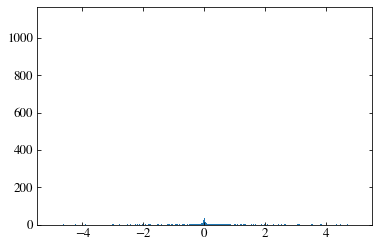

In [29]:
number, bins, patches = plt.hist(w.real, bins=npoint)
Weight = np.zeros([h_node, npoint*2])
for i in range (h_node):
    Weight[i, :npoint] = G2Geq(model.W1.weight.data[i, :2638], weq)
    Weight[i, npoint:] = G2Geq(model.W1.weight.data[i, 2638:], weq)

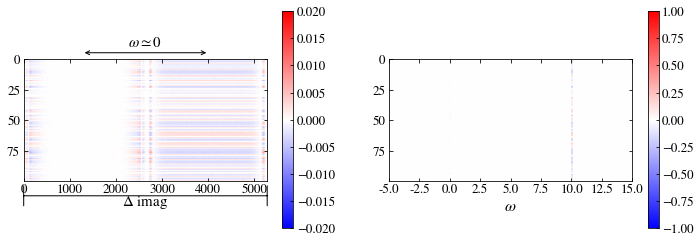

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
op = {'vmin': -0.02, 'vmax': 0.02}
OP = {'vmin': -1, 'vmax': 1}
im1 = ax[0].imshow(np.array(model.W1.weight.data), aspect=0.5*size/h_node, cmap='bwr', **op)
im2 = ax[1].imshow(Weight*np.tile(number, 2), aspect=2000/h_node, cmap='bwr', **OP)
import matplotlib.ticker as ticker
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(500))
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1f'%((x-1000)/200)))
ax[1].set_xlabel(r'$\omega$')
ax[0].annotate('', xy=(0, -0.125), xytext=(1, -0.125), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0})

ax[0].annotate('', xy=(0.25, 1.05), xytext=(0.75, 1.05), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'<->', 'shrinkA':0, 'shrinkB':0})
ax[0].annotate(r'$\omega\simeq0$', xy=(0.5, 1.1), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[0].annotate(r'$\Delta$ imag', xy=(0.5, -0.2), xycoords = 'axes fraction', fontsize=15, ha='center')

cd = plt.colorbar(im1, ax=ax[0])
cd = plt.colorbar(im2, ax=ax[1])
#plt.savefig('NN_Weight_u0.001_10.png')
plt.show()

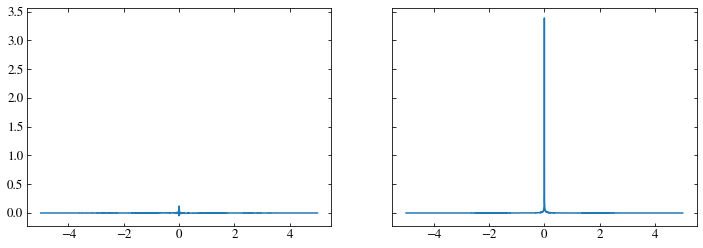

In [35]:
fig, ax = plt.subplots(1,2, figsize=(12, 4), sharey=True)
ax[0].plot(weq, (Weight*np.tile(number, 2))[62, :npoint])
ax[1].plot(weq, (Weight*np.tile(number, 2))[62, npoint:])

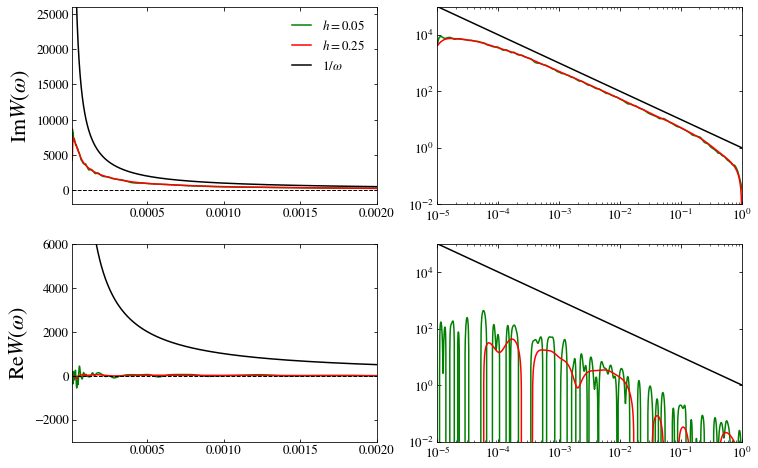

In [36]:
def Wimag(x, n, h, zero): # h = bandwidth
    #a = 1/(sigma)*np.exp(-(x - np.arange(2638))**2/(2*sigma**2)) * np.array(model.W1.weight.data[n, :])
    a = np.exp(-(np.log(np.abs(w.real[zero:]/w.real[x])))**2/(2*h**2)) 
    a = a * np.array(model.W1.weight.data[n, 2638+zero:])
    a = a/(h * (2*np.pi)**0.5)
    a = a/(np.abs(w.real[zero:])+5e-5)
    return np.sum(a)

def Wreal(x, n, h, zero): # h = bandwidth
    #a = 1/(sigma)*np.exp(-(x - np.arange(2638))**2/(2*sigma**2)) * np.array(model.W1.weight.data[n, :])
    a = np.exp(-(np.log(np.abs(w.real[zero:]/w.real[x])))**2/(2*h**2)) 
    a = a * np.array(model.W1.weight.data[n, zero:2638])
    a = a/(h * (2*np.pi)**0.5)
    a = a/(np.abs(w.real[zero:])+5e-5)
    return np.sum(a)

zero=0
W_w_imag_s = np.array([Wimag(i, 62, 0.05, zero) for i in range (zero, 2638)])
W_w_real_s = np.array([Wreal(i, 62, 0.05, zero) for i in range (zero, 2638)])
W_w_imag_L = np.array([Wimag(i, 62, 0.25, zero) for i in range (zero, 2638)])
W_w_real_L = np.array([Wreal(i, 62, 0.25, zero) for i in range (zero, 2638)])

fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(w.real[zero:], W_w_imag_s, c='g', label=r'$h=0.05$')
ax[0,0].plot(w.real[zero:], W_w_imag_L, c='r', label=r'$h=0.25$')
ax[0,0].plot(w.real[zero:], 1.0/w.real[zero:], c='k', label=r'$1/\omega$')
ax[0,0].axhline(0, lw=1, c='k', ls = '--')
ax[0,0].set_xlim(1e-5, 2e-3)
ax[0,0].set_ylim(-2000, 26000)
ax[0,0].legend()
ax[0,0].set_ylabel(r'Im$W(\omega)$', fontsize=22)


ax[0,1].loglog(w.real[zero:], W_w_imag_s, c='g')
ax[0,1].loglog(w.real[zero:], W_w_imag_L, c='r')
ax[0,1].loglog(w.real[zero:], 1.0/w.real[zero:], c='k')
ax[0,1].axhline(0, lw=1, c='k', ls = '--')
ax[0,1].set_xlim(1e-5, 1)
ax[0,1].set_ylim(1e-2, 1e5)


ax[1,0].plot(w.real[zero:], W_w_real_s, c='g')
ax[1,0].plot(w.real[zero:], W_w_real_L, c='r')
ax[1,0].plot(w.real[zero:], 1.0/w.real[zero:], c='k')
ax[1,0].axhline(0, lw=1, c='k', ls = '--')
ax[1,0].set_xlim(1e-5, 2e-3)
ax[1,0].set_ylim(-3000, 6000)
ax[1,0].set_ylabel(r'Re$W(\omega)$', fontsize=22)

ax[1,1].loglog(w.real[zero:], W_w_real_s, c='g')
ax[1,1].loglog(w.real[zero:], W_w_real_L, c='r')
ax[1,1].loglog(w.real[zero:], 1.0/w.real[zero:], c='k')
ax[1,1].axhline(0, lw=1, c='k', ls = '--')
ax[1,1].set_xlim(1e-5, 1)
ax[1,1].set_ylim(1e-2, 1e5)

plt.savefig('W_NN100.png')

# Transformation into matsubara frequency domain (nontrivial)

In [18]:
x_test_iw = np.zeros((len(U1_4)+len(U2_4), 20000), dtype = 'float64')
beta = 10000
for i,u in enumerate(U1_4):
    iw, Giw_r, Giw_i = np.loadtxt(f'../1_dmftsolver/NRG/A_to_Giw/NRG/Bethe_14_beta{beta:d}/Bethe-Giw-{u:.3f}.dat',\
                                       unpack = True, dtype = 'float64')
    x_test_iw[i, :10000], x_test_iw[i, 10000:] = (D/2)**2 * Giw_r, (D/2)**2 * Giw_i
for i,u in enumerate(U2_4):
    iw, Giw_r, Giw_i = np.loadtxt(f'../1_dmftsolver/NRG/A_to_Giw/NRG/Bethe_41_beta{beta:d}/Bethe-Giw-{u:.3f}.dat',\
                                       unpack = True, dtype = 'float64')
    x_test_iw[i+len(U1_4), :10000], x_test_iw[i+len(U1_4), 10000:] = (D/2)**2 * Giw_r, (D/2)**2 * Giw_i
x_test_iw = torch.FloatTensor(-x_test_iw)

In [44]:
def G(x):
    return np.array([simps(x/(1j*omega[i]-w), w) for i in range (N)])
def Geq(x):
    return np.array([simps(x/(1j*omega[i]-weq), weq) for i in range (N)])

def Gmat(x):
    return -np.array([G(xx) for i, xx in enumerate(x)])/np.pi
def Geqmat(x):
    return -np.array([Geq(xx) for i, xx in enumerate(x)])/np.pi

directory = '../1_dmftsolver/NRG'
beta = 10000
N = 10000
w = np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{2.000:.3f}.dat', unpack = True, dtype = 'float64')[0]

omega = np.pi/beta * (2*np.arange(N)+1) # w_n
iwnumber = -Geq(number).imag/np.pi



#W_eff_iw = Geqmat(Weight*number).imag
W_iw_eff_r = Gmat(model.W1.weight.data[:,2638:]).real * iwnumber
W_iw_eff_i = Gmat(model.W1.weight.data[:,2638:]).imag * iwnumber

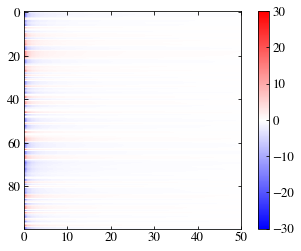

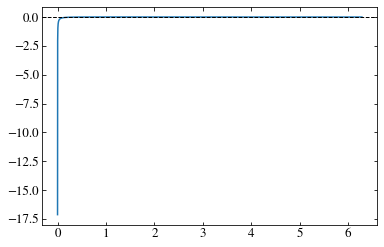

In [45]:
iw_width = 50
im1 = plt.imshow(W_iw_eff_i, aspect = iw_width/100, cmap='bwr', **{'vmin': -30, 'vmax': 30})
plt.xlim(0, iw_width)
cd = plt.colorbar(im1)
plt.show()

plt.plot(omega, W_iw_eff_i[1])
#plt.ylim(-0.01, 0.01)
plt.axhline(0, c='k', lw=1, ls='--')

In [46]:
class TNet(nn.Module):
    def __init__(self, node = None, activate = None):
        super(TNet, self).__init__()
        self.node = node
        self.W1 = nn.Linear(20000, self.node)#, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        #self.W1.weight.data.fill_(0)
        self.W1.weight.data[:, :10000] = torch.FloatTensor(W_iw_eff_r)
        self.W1.weight.data[:, 10000:] = torch.FloatTensor(W_iw_eff_i)
        self.W2.weight.data = model.W2.weight.data
        #self.W1.weight.data = torch.FloatTensor(W_eff_iw)
        self.b1.weight.data = model.b1.weight.data
        self.b2.weight.data = model.b2.weight.data
        '''
        if (activate==nn.Sigmoid or activate==nn.Tanh):
            nn.init.xavier_normal_(self.W1.weight)
            nn.init.xavier_normal_(self.W2.weight)
        else:
            nn.init.kaiming_normal_(self.W1.weight)
            nn.init.kaiming_normal_(self.W2.weight)
        '''

    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)

    def loss1(self, output, y, reg): # regularization l1
        regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    def loss2(self, output, y, reg): # regularization l2
        regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss

    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [47]:
Tmodel = TNet(node = h_node, activate = func)

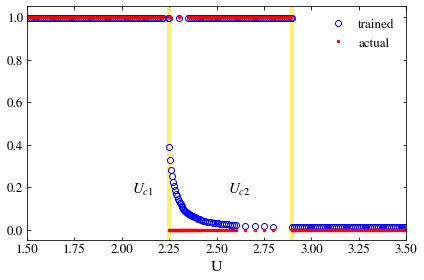

In [48]:

plt.axvline(U_c1_4, c = '#ffee52', lw = '4',  alpha=0.8)
plt.axvline(U_c2_4, c = '#ffee52', lw = '4',  alpha=0.8)
plt.plot(UU_4, Tmodel.forward(x_test_iw).data[:,0], 'bo', mfc='none', label = 'trained')
#plt.plot(UU_4, x_test_iw[:,0]/torch.max(x_test_iw[:, 0]), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
plt.plot(UU_4, y_test_4[:,0], 'r.', ms = 5, label = 'actual')
plt.xlim(1.5, 3.5)
plt.xlabel('U')
plt.annotate(r'$U_{c1}$', xy=(0.305, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
plt.annotate(r'$U_{c2}$', xy=(0.56, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.title(r'$\beta=100$', fontsize=16)
plt.legend()

plt.tight_layout(w_pad=1.5)
#plt.savefig('LogisticRegression_outputcubic_u0.001.png')

### ED data

[-1.67494735e+00 -7.14427384e-01  2.61008098e-04  7.12975771e-01
  1.67489392e+00] [ 0.30949093 -0.16820854  0.00101162 -0.16786696  0.30971471]


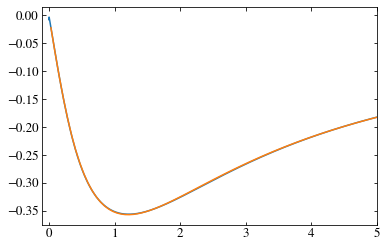

In [36]:
def EDbath(e, V):
    return np.array([np.sum(V**2/(1j*omega[i]-e)) for i in range (aa)])

beta = 100
directory1 = '../1_dmftsolver/ED'
a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{3.00:.2f}', dtype = 'float64')
iw, Giwr, Giwi = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/Giw-{3.00:.2f}.dat',\
                                       unpack = True, dtype = 'float64')
e, V = a[:5], a[5:]

aa = 10000
omega = np.pi/aa * (2*np.arange(aa)+1)
plt.plot(omega[:aa], 4*EDbath(e,V).imag)
plt.plot(iw, Giwi)
plt.xlim(-0.1, 5)
print(e,V)

In [49]:
beta = 100
directory1 = '../1_dmftsolver/ED'
up_num = 211
dn_num = 211
U1_ed = np.zeros(up_num, dtype = 'float64')
U2_ed = np.zeros(dn_num, dtype = 'float64')
U_c1_ed, U_c2_ed = 2.4, 2.93

U = np.array([0.01*i for i in range(50, 501)])
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U1_ed[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U2_ed[n] = u
    n += 1

x_test_ed = np.zeros((len(U1_ed)+len(U2_ed), 20000), dtype = 'float64')

for i,u in enumerate(U1_ed):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    mid = EDbath(e,V)
    x_test_ed[i][:10000], x_test_ed[i][10000:] = mid.real, mid.imag
for i,u in enumerate(U2_ed):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    mid = EDbath(e,V)
    x_test_ed[i+len(U1_ed)][:10000], x_test_ed[i+len(U1_ed)][10000:] = mid.real, mid.imag
    
    
'''
for i,u in enumerate(U1_ed):
    iw, Giwr, Giwi = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/Giw-{u:.2f}.dat', \
                                unpack = True, dtype = 'float64')
    x_test_ed[i][:5000] = (D/2)**2 * Giwi
for i,u in enumerate(U2_ed):
    iw, Giwr, Giwi = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/Giw-{u:.2f}.dat', \
                                unpack = True, dtype = 'float64')
    x_test_ed[i+len(U1_ed)][:5000] = (D/2)**2 * Giwi
'''
x_test_ed = torch.FloatTensor(-x_test_ed)


y_temp1 = np.array(U1_ed < U_c2_ed)
y_temp2 = np.array(U2_ed < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_ed = np.stack([y_temp, ~y_temp], axis = 1)
y_test_ed = torch.FloatTensor(y_test_ed)
UU_ed = np.concatenate((U1_ed, U2_ed))

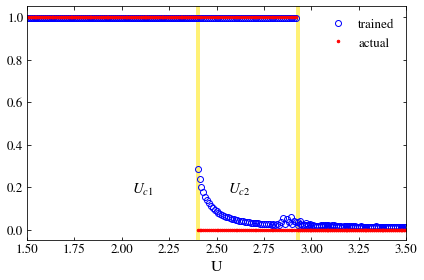

In [50]:
plt.axvline(U_c1_ed, c = '#ffee52', lw = '4',  alpha=0.8)
plt.axvline(U_c2_ed, c = '#ffee52', lw = '4',  alpha=0.8)
plt.plot(UU_ed, Tmodel.forward(x_test_ed).data[:,0], 'bo', mfc='none', label = 'trained')
#plt.plot(UU_ed, x_test_ed[:,0]/torch.max(x_test_ed[:, 0]), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
#plt.plot(UU_ed, np.average(x_test_ed[:,0:150], axis=1)/np.max(np.average(x_test_ed[:,0:150], axis=1)), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
plt.plot(UU_ed, y_test_ed[:,0], 'r.', ms = 5, label = 'actual')
plt.xlim(1.5, 3.5)
plt.xlabel('U')
plt.annotate(r'$U_{c1}$', xy=(0.305, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
plt.annotate(r'$U_{c2}$', xy=(0.56, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.title(r'$\beta=100$', fontsize=16)
plt.legend()

plt.tight_layout(w_pad=1.5)
#plt.savefig('LogisticRegression_outputcubic_u0.001.png')

## Saving result

In [20]:
model.W1.weight.data.shape, model.W2.weight.data.shape, Weight.shape, W_iw_eff.shape

NameError: name 'W_iw_eff' is not defined

In [37]:
np.savetxt('frozen_mat/all_NN100_W1.txt', np.array(model.W1.weight.data))
np.savetxt('frozen_mat/all_NN100_W2.txt', np.array(model.W2.weight.data))
#np.savetxt('frozen_mat/all_NN100_W1_re.txt', Weight)
#np.savetxt('frozen_mat/all_NN100_W1_iw_r.txt', W_iw_eff_r)
#np.savetxt('frozen_mat/all_NN100_W1_iw_i.txt', W_iw_eff_i)
np.savetxt('frozen_mat/all_NN100_b1.txt', np.array(model.b1.weight.data))
np.savetxt('frozen_mat/all_NN100_b2.txt', np.array(model.b2.weight.data))

In [38]:
torch.save(model.state_dict(), 'frozen_mat/NN100model.pth')
#torch.save(Tmodel.state_dict(), 'frozen_mat/TNN100model.pth')